## Week2 Basic Homework

In [1]:
!pip install datasets sacremoses
##sacremoses는 영어를 위한 tokenizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## [MY CODE] 동일한 IMDB 데이터 로드 및 collate_fn 함수 변경

In [17]:
import numpy as np

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').long()

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

# 기존 collate_fn 함수
# def collate_fn(batch):
#   max_len = 400
#   texts, labels = [], []
#   for row in batch:
#     labels.append(row['label'])
#     texts.append(row['text'])

#   texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
#   labels = torch.LongTensor(labels)

#   return texts, labels

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
        texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)

    return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## [MY CODE] dataset 확인

In [4]:
def check_collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
        texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids)) # 전체 저장

    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)

    return texts, labels

data_check_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=check_collate_fn
)

for check_data in data_check_loader:
    check_inputs, check_labels = check_data
    break #하나만 확인

print(check_inputs[0], check_labels[0])

tensor([  101,  1045,  2293, 16596,  1011, 10882,  1998,  2572,  5627,  2000,
         2404,  2039,  2007,  1037,  2843,  1012, 16596,  1011, 10882,  5691,
         1013,  2694,  2024,  2788,  2104, 11263, 25848,  1010,  2104,  1011,
        12315,  1998, 28947,  1012,  1045,  2699,  2000,  2066,  2023,  1010,
         1045,  2428,  2106,  1010,  2021,  2009,  2003,  2000,  2204,  2694,
        16596,  1011, 10882,  2004, 17690,  1019,  2003,  2000,  2732, 10313,
         1006,  1996,  2434,  1007,  1012, 10021,  4013,  3367, 20086,  2015,
         1010, 10036, 19747,  4520,  1010, 25931,  3064, 22580,  1010,  1039,
         2290,  2008,  2987,  1005,  1056,  2674,  1996,  4281,  1010,  1998,
        16267,  2028,  1011,  8789,  3494,  3685,  2022,  9462,  2007,  1037,
         1005, 16596,  1011, 10882,  1005,  4292,  1012,  1006,  1045,  1005,
         1049,  2469,  2045,  2024,  2216,  1997,  2017,  2041,  2045,  2040,
         2228, 17690,  1019,  2003,  2204, 16596,  1011, 10882, 

## [LOG] labels는 102를 제외한 마지막([-2]), inputs은 전체를 가져와서 데이터 파악.

## [MY CODE] output 수 확인

In [5]:
## my code
tmp_list = []
for data in train_loader:
    inputs, labels = data
    tmp_list.extend([int(x) for x in labels])

tmp_list = list(dict.fromkeys(tmp_list))
tmp_list.sort()
len(tmp_list)

2253

In [6]:
d_output = len(tmp_list)
print(tmp_list[:20])

[999, 1000, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019]


## [LOG] trainset 기준으로 마지막 토큰의 유형은 2253개로 나타남
## label의 유형이 전체 데이터의 10%정도이므로 데이터가 너무 적어 학습이 힘들 것 같음

## 기존코드: self attention, transformer layer 및 positioning encoding

In [10]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

In [11]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

In [12]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


## [MY CODE] model 작성, 마지막 layer의 output 변경

In [14]:
from torch.optim import Adam

class LastWordClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

        # 마지막 단어를 예측하기 위해 마지막 layer에서 output을 바꿔준다.
        # label 값을 그대로 활용하기 위해 vocab_size를 output으로 입력
        self.classification = nn.Linear(d_model, self.vocab_size)


    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]
        x = self.classification(x)

        return x


model = LastWordClassifier(vocab_size=len(tokenizer), d_model=32, n_layers=2, dff=32)
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

## [MY CODE] 학습 진행

In [18]:
import torch.nn.functional as F

n_epochs = 50
train_acc_list = []
test_acc_list = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    labels_mapped = []
    inputs, labels = inputs.to('cuda'), labels.to('cuda').long()

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

Epoch   0 | Train Loss: 1103.4495077133179
=========> Train acc: 0.558 | Test acc: 0.563
Epoch   1 | Train Loss: 1078.5623288154602
=========> Train acc: 0.559 | Test acc: 0.561
Epoch   2 | Train Loss: 1060.7426260709763
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   3 | Train Loss: 1044.5829422473907
=========> Train acc: 0.559 | Test acc: 0.563
Epoch   4 | Train Loss: 1034.79516851902
=========> Train acc: 0.560 | Test acc: 0.551
Epoch   5 | Train Loss: 1023.000944018364
=========> Train acc: 0.563 | Test acc: 0.557
Epoch   6 | Train Loss: 1011.1268557310104
=========> Train acc: 0.564 | Test acc: 0.556
Epoch   7 | Train Loss: 1000.6472203731537
=========> Train acc: 0.566 | Test acc: 0.549
Epoch   8 | Train Loss: 985.1116924285889
=========> Train acc: 0.567 | Test acc: 0.549
Epoch   9 | Train Loss: 971.6574561595917
=========> Train acc: 0.567 | Test acc: 0.551
Epoch  10 | Train Loss: 959.7650427818298
=========> Train acc: 0.568 | Test acc: 0.553
Epoch  11 | Train Loss: 942

## [MY CODE] 학습 결과 비교 plot

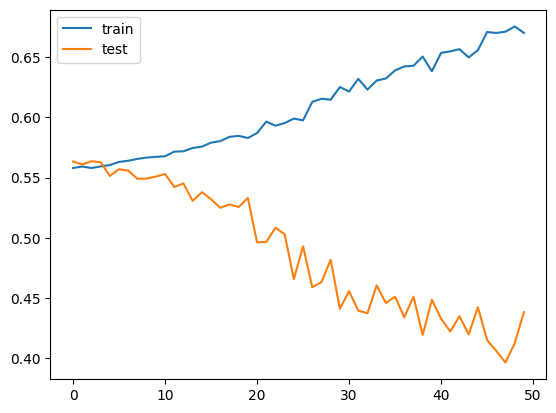

In [19]:
from matplotlib import pyplot as plt
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_acc_list, test_acc_list)

## [LOG] testset의 정확도가 떨어지고 trainset의 정확도가 올라가는 것으로 보아 overfitting 된 것 같음